In [1]:
import numpy as np
import math
import pandas as pd
import time
import glob
!pip install MulticoreTSNE

from MulticoreTSNE import MulticoreTSNE as TSNE
#from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
!pip install plotly
import plotly.graph_objects as go
from sklearn import mixture, svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68517 sha256=dee138f827460ab410f100cce97711ee264f882253e382ab7b98c24ddc77a29c
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [20]:
def boxcar_center(a, n):

  a1 = pd.Series(a)
  moving_avg = np.array(a1.rolling(window = n,min_periods=1,center = True).mean())
  
  return moving_avg 

from scipy.stats import mode 
def boxcar_center_mode(a, n):

  a1 = pd.Series(a)
  moving_avg = (np.array(a1.rolling(window = n).apply(lambda x: x.mode(x))))

  return moving_avg 

def adp_filt(currDf=None,*args,**kwargs):

    lIndex = []
    xIndex = []
    yIndex = []
    currDf = np.array(currDf[1:])
    for header in range(len(currDf[0])):
        if currDf[0][header] == "likelihood":
            lIndex.append(header)
        elif currDf[0][header] == "Angle":
            xIndex.append(header)
        elif currDf[0][header] == "d/dt":
            yIndex.append(header)
    print('Replacing data-driven low likelihood positions with the most recent highly probable position... \n')
    start_time = time.time()
    currDf = np.array(currDf)
    currDf1 = currDf[:,1:]
    datax=currDf1[:,np.array(xIndex)-1]
    datay=currDf1[:,np.array(yIndex)-1]
    data_lh=currDf1[:,np.array(lIndex)-1]
    currDf_filt = np.zeros((datax.shape[0]-1,(datax.shape[1])*2))
    perc_rect = []
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in range(data_lh.shape[1]):
        if x <= 2:
            a,b = np.histogram(data_lh[1:,x].astype(np.float))
            rise_a = np.where(np.diff(a) >= 0)
            if rise_a[0][0] > 1:
                llh = (b[rise_a[0][0]]+b[rise_a[0][0]-1])/2
            else:
                llh = (b[rise_a[0][1]]+b[rise_a[0][1]-1])/2
        else:
            llh = 0.2
        data_lh_float = data_lh[1:,x].astype(np.float)
        perc_rect[x] = len(np.where(data_lh_float < llh)) / data_lh.shape[1]
        currDf_filt[0,(2*x):(2*x + 2)] = np.hstack([datax[1,x],datay[1,x]])
        # replacing with most recent highly probable positions
        for i in range(1,data_lh.shape[0]-1):
            if data_lh_float[i] < llh:
                currDf_filt[i,(2*x):(2*x + 2)] = currDf_filt[i - 1,(2*x):(2*x + 2)]
            else:
                currDf_filt[i,(2*x):(2*x + 2)] = np.hstack([datax[i,x],datay[i,x]])
    currDf_filt = np.array(currDf_filt[1:])
    currDf_filt = currDf_filt.astype(np.float)
    print("--- High-pass filter took %s seconds ---" % (time.time() - start_time))
    
    return currDf_filt, perc_rect

def bsoid_assign(data,fps,comp,kclass,it,*args,**kwargs):
    import pandas as pd
    win_len = np.int(np.round(0.05/(1/fps))*2-1)
    print('Obtaining features from dataset... \n')
    start_time = time.time()
    feats = list()
    if comp == 1:
        if len(np.vstack(data)) < 15000:
          p = 1
          exag = 4
          lr = 500
        else:
          p = round(np.vstack(data).shape[0]/300)
          p=50
          print('p',p)
          exag = round(np.vstack(data).shape[0]/2500)
          exag=1
          lr = round(np.log(np.vstack(data).shape[0])/0.02)
          print(lr)
        np.random.seed(0)
        print('f_10fps',np.vstack(data).shape)
        f_10fps_norm = np.vstack(data)/np.std(np.vstack(data).T,axis=1)
        start_time = time.time()
        print('Running the compiled data through t-SNE collapsing the 7 features onto 3 action space coordinates... \n')
        tsne_feats=TSNE(n_components=3,perplexity=p, early_exaggeration=exag, learning_rate=lr, n_jobs=4).fit_transform(f_10fps_norm)
        print("--- TSNE embedding took %s seconds ---" % (time.time() - start_time))
        ## Run a Gaussian Mixture Model Expectation Maximization to group the t-SNE clusters
        start_time = time.time()
        print(tsne_feats)
        tsne_xyz = pd.DataFrame(tsne_feats)
        tsne_xyz = tsne_xyz.to_csv('/content/drive/MyDrive/Whisker_Data/tsne_feats_20_class_all')
        gmm = mixture.GaussianMixture(n_components=kclass, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=it, init_params='random').fit(tsne_feats)
        labels = gmm.predict(tsne_feats)
        tsne_labels = pd.DataFrame(labels)
        tsne_labels = tsne_labels.to_csv('/content/drive/MyDrive/Whisker_Data/tsne_labels_20_class_all')
        print("--- Gaussian mixtures took %s seconds ---" % (time.time() - start_time))
        print(" Plotting t-SNE with GMM assignments... ")
        uk = list(np.unique(labels))
        uniqueLabels = []
        for i in labels:
          indexVal = uk.index(i)
          uniqueLabels.append(indexVal)
        R = np.linspace(0,1,len(uk))
        color=plt.cm.hsv(R)
        print(tsne_feats.shape)
        fig = go.Figure(data=[go.Scatter3d(x=tsne_feats[:,0], y=tsne_feats[:,1], z=tsne_feats[:,2], mode='markers', 
                                     marker=dict(size=2.5, color=color[uniqueLabels], opacity=0.8))])
        fig.show()
        print('TADA! \n')

    return f_10fps,tsne_feats,np.array(uniqueLabels),fig

def bsoid_mdl2(f_10fps=None,labels=None,hldout=None,cv_it=None,*args,**kwargs):   
    
    print('Parsing features into train and test sets')
    feats_T=f_10fps
    labels_T=labels
    #np.random.seed(0)
    feats_train, feats_test, labels_train, labels_test = train_test_split(feats_T, labels_T, test_size=hldout, 
                                                                          random_state=0)
    start_time = time.time()
    print('Training an SVM classifier (kernel trick: Gaussian)... \n')
    clf = svm.SVC(gamma=0.005, C= 100)
    clf.fit(feats_train, labels_train)
    scores = cross_val_score(clf, feats_test, labels_test, cv=cv_it)
    print("--- Training classifier and performing cross-validation {} times took %s seconds ---".format(cv_it) % (time.time() - start_time))
    fig = plt.figure(num=None, figsize=(1.5, 2), dpi=300, facecolor='w', edgecolor='k')
    fig.suptitle("Performance on {} % Data".format(hldout*100), fontsize=8, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.boxplot(scores, notch=None)
    ax.set_xlabel('SVM',fontsize=8)
    ax.set_ylabel('Accuracy',fontsize=8)
    
    return clf,fig,scores

In [6]:
from google.colab import drive
drive.mount("/content/drive/",True)

Mounted at /content/drive/


In [14]:
import time
# import sys
# import os
# sys.path.append(os.path.dirname(sys.path[0]))
# # print(sys.path)

lesn_angles_list = []
ctrl_angles_list = []
path = "/content/drive/MyDrive/Whisker_Data/lesion-Anna-2019-11-24/videos/"
datelist = ["angles"] # get the folder name
all_files = list()
print('Compiling all files...')
for dates in datelist:
    for file in glob.glob(path + dates + "/*.csv"):
        lesn_angles_list.append(file)

path = "/content/drive/MyDrive/Whisker_Data/control-Anna-2019-12-12/videos/"
datelist = ["angles"] # get the folder name
all_files = list()
print('Compiling all files...')
for dates in datelist:
    for file in glob.glob(path + dates + "/*.csv"):
        ctrl_angles_list.append(file)

all_files = lesn_angles_list + ctrl_angles_list

li = []
li_filt = []
perc_rect_li = []
print('High-pass filter for low-likelihood pose estimation:')
for filename in all_files:
    print(filename)
    currDf = pd.read_csv(filename,low_memory=False)
    print(currDf)
    currDf_filt,perc_rect = adp_filt(currDf)
    li.append(currDf)
    perc_rect_li.append(perc_rect)
    li_filt.append(currDf_filt)
data = np.array(li_filt)
print('You have compiled .csv files into a',data.shape,'data list.')
data = data
# print(data)

Compiling all files...
Compiling all files...
High-pass filter for low-likelihood pose estimation:
/content/drive/MyDrive/Whisker_Data/lesion-Anna-2019-11-24/videos/angles/1-11182019211833-angles.csv
       Unnamed: 0  ... DeepLabCut_angles.20
0             NaN  ...                   R3
1             NaN  ...           likelihood
2             0.0  ...   0.6819549836218357
3             1.0  ...   0.7905144281685352
4             2.0  ...   0.9744939357042313
...           ...  ...                  ...
24072     24070.0  ...   0.9999364614486694
24073     24071.0  ...   0.9997899979352951
24074     24072.0  ...   0.9997974932193757
24075     24073.0  ...   0.9999447911977768
24076     24074.0  ...   0.9564212262630463

[24077 rows x 22 columns]
Replacing data-driven low likelihood positions with the most recent highly probable position... 

--- High-pass filter took 2.0333940982818604 seconds ---
/content/drive/MyDrive/Whisker_Data/lesion-Anna-2019-11-24/videos/angles/1-11192019095251-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [15]:
data2 = np.array([data[0][:,1],data[0][:,3],data[0][:,5],data[0][:,7],data[0][:,9],data[0][:,11],data[0][:,13]])

In [22]:
# change fps = camera frame-rate
import time
# f_10fps,tsne_feats,labels,tsne_fig = bsoid_assign(data,fps = 60,comp = 1,kclass = 50,it = 30)

dat = []
for i in range(len(data)):
    dat.append(data[i])
dat1 = np.array(dat)
dat2 = np.vstack(data[:2])
f_10fps,tsne_feats,labels,tsne_fig = bsoid_assign(data,fps = 400,comp = 1,kclass = 20,it = 20)


In [9]:
import pandas as pd
labels = pd.read_csv('/content/drive/MyDrive/Whisker_Data/tsne_labels_30_class_all')
labels.columns = ['one','two']
uk = list(np.unique(labels['one']))
uniqueLabels = []
for i in labels['two']:
    indexVal = uk.index(i)
    uniqueLabels.append(indexVal)
#clf,acc_fig,scores = bsoid_mdl2(f_10fps=np.vstack(data),labels=np.array(uniqueLabels),hldout=0.6,cv_it=1)


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(2, 3), dpi=300, facecolor='w', edgecolor='k')
R = np.linspace(0,1,len(np.unique(labels)))
color=plt.cm.hsv(R)
feat_ls = ("Distance between snout & center forepaw","Distance between snout & center hind paw","forepaw distance",
              "Body length","Angle","Snout speed","Proximal tail speed")
for j in range(0,f_10fps.shape[0]):
  fig = plt.figure(num=None, figsize=(2, 3), dpi=300, facecolor='w', edgecolor='k')
  for i in range(0,len(np.unique(labels))):
    plt.subplot(len(np.unique(labels)), 1, i+1)
    if j == 2 or j == 3 or j == 5 or j == 6:
      plt.hist(f_10fps[j,labels == i],
              bins = np.linspace(0,np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:])),
              range = (0,np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:])),
              color = color[i], density=True)
      plt.xticks(fontsize=6)
      plt.yticks(fontsize=6)
      fig.suptitle("{} pixels".format(feat_ls[j]), fontsize=8, fontweight='bold')
      plt.xlim(0,np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:]))
      if i < len(np.unique(labels))-1:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
      plt.hist(f_10fps[j,labels == i],
              bins = np.linspace(np.mean(f_10fps[j,:])-3*np.std(f_10fps[j,:]),np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:])),
              range = (np.mean(f_10fps[j,:])-3*np.std(f_10fps[j,:]),np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:])),
              color = color[i], density=True)
      plt.xticks(fontsize=6)
      plt.yticks(fontsize=6)
      plt.xlim(np.mean(f_10fps[j,:])-3*np.std(f_10fps[j,:]),np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:]))
      fig.suptitle("{} pixels".format(feat_ls[j]), fontsize=8, fontweight='bold')
      if i < len(np.unique(labels))-1:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

In [ ]:
import matplotlib

frame_ps = 400
feats_ps = 400
num_feat_per_csv = []
samples_per_csv = []
for i in range(len(data)):
    num_feat_per_csv.append(int(data[i].shape[0]/(frame_ps/feats_ps)))
    samples_per_csv.append(int(data[i].shape[0]))
    #print(samples_per_csv)

idx = 0
y_range = [0,180]
syllable_data = []
label = []
features = []
print(np.array(uniqueLabels).shape)
for i in range(len(num_feat_per_csv)):
    if i < len(lesn_angles_list):
        print("Lesion video dataset: ", i+1)
        csv_path = lesn_angles_list[i]
        label.append(1) 

    elif i >= len(lesn_angles_list):
        print("Control video dataset: ", i-len(lesn_angles_list)+1)
        csv_path = ctrl_angles_list[i-len(lesn_angles_list)]
        label.append(0)

    dim = num_feat_per_csv[i]

    xs = np.linspace(0, dim/feats_ps, dim).reshape(-1,1).transpose()
    xs = np.vstack((xs,xs))
    ys = np.vstack((y_range[0]*np.ones(dim).reshape(-1,1).transpose(),y_range[1]*np.ones(dim).reshape(-1,1).transpose()))
    syl = np.array(uniqueLabels)[idx:idx+samples_per_csv[i]].reshape(-1,1).transpose()
    zs = np.array(uniqueLabels)[idx:idx+num_feat_per_csv[i]].reshape(-1,1).transpose()
    if idx == 0:
      syllable_data = syl[:,:23951]
      features = data[i][:23951,:]
    else:
      syllable_data = np.vstack((syllable_data,syl[:,:23951]))
      features = np.vstack((features,data[i][:23951,:]))
    zs = np.vstack((zs,zs))

    idx += num_feat_per_csv[i]
    color_list = ["red","orange", "yellow", "green","blue", "purple", "pink", "white", "grey", "black"]
    custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list[:np.max(zs)+1])


    file = pd.read_csv(csv_path, header=[1,2]).astype(float)
    angle_data = pd.DataFrame(file)
    fig, ax1 = plt.subplots( figsize=(20,6))
    plt.pcolor(xs, ys, zs, cmap=custom_cmap, alpha=0.3)
    plt.colorbar()

    deriv_threshold = 180 # min abs(movement) to count as moving [deg/sec]
    f_samp = 400
    time = np.linspace(0, len(angle_data['L1','Angle'])/f_samp, len(angle_data['L1','Angle'])) # Time for plotting


    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Whisker angle')
    ax1.set_ylim(y_range)

    ax1.plot(time, angle_data['L1','Angle'])
    ax1.plot(time, angle_data['L2','Angle'])
    ax1.plot(time, angle_data['L3','Angle'])
    ax1.plot(time, angle_data['R1','Angle'])
    ax1.plot(time, angle_data['R2','Angle'])
    ax1.plot(time, angle_data['R3','Angle'])

    plot_deriv = False
    if plot_deriv:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Avg normalized whisker angle derivative')
        ax2.set_ylim([0,5000])

        ax2.plot(time, angle_data['L1','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['L2','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['L3','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['R1','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['R2','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['R3','d/dt'], alpha = 0.3)
        ax2.plot(time, deriv_threshold*np.ones(len(time)))

    fig.legend(['L1', 'L2', 'L3', 'R1', 'R2', 'R3'], bbox_to_anchor=(0.96, 0.95))
    #, 'd_L1/dt', 'd_L2/dt', 'd_L3/dt', 'd_R1/dt', 'd_R2/dt', 'd_R3/dt', 'thresh'
    fig.tight_layout()

    if i < len(lesn_angles_list):
        ax1.set_title("Lesion video dataset: " + str(i+1))

    elif i >= len(lesn_angles_list):
        ax1.set_title("Control video dataset: " + str(i-len(lesn_angles_list)+1))

    plt.xlim(0,60)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

1197550
1197550


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Text(0.5, 0, 'syllable')

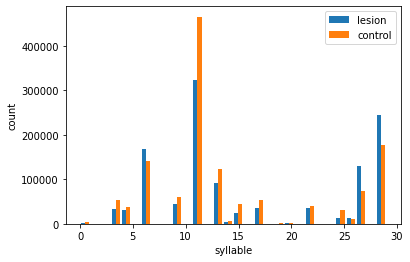

In [ ]:
print(len(syllable_data[:50,:].reshape(-1,1).tolist()))
print(len(uniqueLabels[:1197550]))
plt.hist([uniqueLabels[:1197550],uniqueLabels[1197550:]],bins=30,label=['lesion','control'])
#plt.hist(uniqueLabels[1197550:],bins=30,label='control')
plt.legend()
plt.ylabel('count')
plt.xlabel('syllable')

In [3]:
print(np.array(label).shape)
print(syllable_data)
print(np.array(syllable_data).shape)
print(features.shape)
print(2519859/23951)
print(np.array(features.reshape(105,-1,14).shape))
features = features.reshape(105,-1,14)

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

import keras
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

accuracies = []

for i in range(1):

    model = Sequential()
    model.add(LSTM(264, input_shape=(23951,1),return_sequences=True))
    model.add(LSTM(64, input_shape=(23951,254)))
    model.add(Dense(1, activation='sigmoid'))

    #targets = label.copy()

    #label = tf.keras.utils.to_categorical(targets).reshape(-1,2)
    #label = pd.get_dummies(label.T, sparse=True)
    #print(label.shape)
    #print(label)
    print(data[0].shape)

    x_train, x_val, y_train, y_val = train_test_split(np.array(syllable_data).reshape(105,23951,1),np.array(label),test_size=0.3,shuffle=True)
    #x_val, x_test, y_val, y_test = train_test_split(x_val,y_val,test_size=0.5,shuffle=True)

    print(x_train[0].shape)
    adam = Adam(lr=0.0001)
    chk = ModelCheckpoint('/content/drive/MyDrive/Whisker_Data/best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(np.array(x_train), np.array(y_train), epochs=500, batch_size=32, callbacks=[chk], validation_data=(x_val,y_val))


    #model = load_model('/content/drive/MyDrive/Whisker_Data/best_model.pkl')

    from sklearn.metrics import accuracy_score
    test_preds = model.predict_classes(x_val)
    accuracies.append(accuracy_score(test_preds, y_val))
    print(accuracy_score(test_preds, y_val))

(24074, 14)
(23951, 1)
Epoch 1/500
3/3 [==============================] - 12s 3s/step - loss: 0.6947 - accuracy: 0.4966 - val_loss: 0.6955 - val_accuracy: 0.4375
Epoch 2/500
3/3 [==============================] - 8s 3s/step - loss: 0.6913 - accuracy: 0.4888 - val_loss: 0.6960 - val_accuracy: 0.4688
Epoch 3/500
3/3 [==============================] - 8s 3s/step - loss: 0.6903 - accuracy: 0.5083 - val_loss: 0.6971 - val_accuracy: 0.4688
Epoch 4/500
3/3 [==============================] - 8s 3s/step - loss: 0.6897 - accuracy: 0.4917 - val_loss: 0.6980 - val_accuracy: 0.4688
Epoch 5/500
3/3 [==============================] - 8s 3s/step - loss: 0.6882 - accuracy: 0.5308 - val_loss: 0.6990 - val_accuracy: 0.4375
Epoch 6/500
3/3 [==============================] - 8s 3s/step - loss: 0.6862 - accuracy: 0.5161 - val_loss: 0.7000 - val_accuracy: 0.4375
Epoch 7/500
3/3 [==============================] - 8s 3s/step - loss: 0.6871 - accuracy: 0.4927 - val_loss: 0.7020 - val_accuracy: 0.4375
Epoch 8/50

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

import keras
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

accuracies = []

for i in range(10):

    model = Sequential()
    model.add(LSTM(264, input_shape=(23951,14),return_sequences=True))
    model.add(LSTM(64, input_shape=(23951,254)))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=keras.regularizers.l2(0.02)))

    #targets = label.copy()

    #label = tf.keras.utils.to_categorical(targets).reshape(-1,2)
    #label = pd.get_dummies(label.T, sparse=True)
    #print(label.shape)
    #print(label)
    print(data[0].shape)

    x_train, x_val, y_train, y_val = train_test_split(np.array(features),np.array(label),test_size=0.3,shuffle=True)
    #x_val, x_test, y_val, y_test = train_test_split(x_val,y_val,test_size=0.5,shuffle=True)

    print(x_train[0].shape)
    adam = Adam(lr=0.0002)
    chk = ModelCheckpoint('/content/drive/MyDrive/Whisker_Data/best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(np.array(x_train), np.array(y_train), epochs=150, batch_size=16, callbacks=[chk], validation_data=(x_val,y_val))


    #model = load_model('/content/drive/MyDrive/Whisker_Data/best_model.pkl')

    from sklearn.metrics import accuracy_score
    test_preds = model.predict_classes(x_val)
    accuracies.append(accuracy_score(test_preds, y_val))
    print(accuracy_score(test_preds, y_val))
    print(accuracies)

(24074, 14)
(23951, 14)
Epoch 1/150
5/5 [==============================] - 13s 2s/step - loss: 0.7549 - accuracy: 0.5177 - val_loss: 0.6734 - val_accuracy: 0.6875
Epoch 2/150
5/5 [==============================] - 10s 2s/step - loss: 0.6367 - accuracy: 0.7208 - val_loss: 0.6158 - val_accuracy: 0.7188
Epoch 3/150
5/5 [==============================] - 10s 2s/step - loss: 0.5543 - accuracy: 0.7737 - val_loss: 0.5829 - val_accuracy: 0.7500
Epoch 4/150
5/5 [==============================] - 10s 2s/step - loss: 0.4619 - accuracy: 0.8482 - val_loss: 0.5557 - val_accuracy: 0.7500
Epoch 5/150
5/5 [==============================] - 10s 2s/step - loss: 0.4367 - accuracy: 0.8443 - val_loss: 0.5358 - val_accuracy: 0.7500
Epoch 6/150
5/5 [==============================] - 10s 2s/step - loss: 0.3758 - accuracy: 0.9283 - val_loss: 0.5242 - val_accuracy: 0.7812
Epoch 7/150
5/5 [==============================] - 10s 2s/step - loss: 0.3416 - accuracy: 0.9381 - val_loss: 0.5089 - val_accuracy: 0.7812
Epo

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



0.84375
[0.84375]
(24074, 14)
(23951, 14)
Epoch 1/150
5/5 [==============================] - 12s 2s/step - loss: 0.7082 - accuracy: 0.5737 - val_loss: 0.6311 - val_accuracy: 0.7188
Epoch 2/150
5/5 [==============================] - 9s 2s/step - loss: 0.5813 - accuracy: 0.7049 - val_loss: 0.5740 - val_accuracy: 0.7188
Epoch 3/150
5/5 [==============================] - 10s 2s/step - loss: 0.5076 - accuracy: 0.7394 - val_loss: 0.5426 - val_accuracy: 0.7500
Epoch 4/150
5/5 [==============================] - 10s 2s/step - loss: 0.4427 - accuracy: 0.8549 - val_loss: 0.5135 - val_accuracy: 0.7812
Epoch 5/150
5/5 [==============================] - 10s 2s/step - loss: 0.3796 - accuracy: 0.8528 - val_loss: 0.4970 - val_accuracy: 0.7812
Epoch 6/150
5/5 [==============================] - 10s 2s/step - loss: 0.3278 - accuracy: 0.9275 - val_loss: 0.4861 - val_accuracy: 0.7812
Epoch 7/150
5/5 [==============================] - 10s 2s/step - loss: 0.3282 - accuracy: 0.9487 - val_loss: 0.4860 - val_acc

In [ ]:
!pip install kmeans-pytorch
import torch
import numpy as np
from kmeans_pytorch import kmeans

import pandas as pd
#tsne_feats = pd.read_csv('/content/drive/MyDrive/Whisker_Data/tsne_feats_30_class_all')

# data
dims, num_clusters = 3, 10
#x = torch.from_numpy(np.array(tsne_feats))
x = torch.from_numpy(np.vstack(data)/np.std(np.vstack(data).T,axis=1))
# kmeans
cluster_ids_x, cluster_centers = kmeans(
    X=x, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:0')
)



running k-means on cuda:0..


[running kmeans]: 124it [03:06,  1.48s/it, center_shift=0.000093, iteration=124, tol=0.000100]

In [ ]:
import matplotlib
uniqueLabels = cluster_ids_x

"""
Determine data distribution
i.e. number of samples (features/labels)
     corresponding to each input file
"""
frame_ps = 400
feats_ps = 400
num_feat_per_csv = []
for i in range(len(data)):
    num_feat_per_csv.append(int(data[i].shape[0]/(frame_ps/feats_ps)))

"""
Plot labels (classes) as colors over time
for each input file (.csv)
* You can plot over this
"""

idx = 0
# y_range = [-180,180]
y_range = [0,180]
syllable_data = []
label = []
features = []
for i in range(len(num_feat_per_csv)):
# for i in range(2):

    if i < len(lesn_angles_list):
        print("Lesion video dataset: ", i+1)
        csv_path = lesn_angles_list[i]
        label.append(1) 

    elif i >= len(lesn_angles_list):
        print("Control video dataset: ", i-len(lesn_angles_list)+1)
        csv_path = ctrl_angles_list[i-len(lesn_angles_list)]
        label.append(0)

    print(data[i])
    dim = num_feat_per_csv[i]

    xs = np.linspace(0, dim/feats_ps, dim).reshape(-1,1).transpose()
    xs = np.vstack((xs,xs))
    ys = np.vstack((y_range[0]*np.ones(dim).reshape(-1,1).transpose(),y_range[1]*np.ones(dim).reshape(-1,1).transpose()))
    zs = np.array(uniqueLabels)[idx:idx+num_feat_per_csv[i]].reshape(-1,1).transpose()
    if idx == 0:
      syllable_data = zs[:,:23951]
      features = data[i][:23951,:]
    else:
      syllable_data = np.vstack((syllable_data,zs[:,:23951]))
      features = np.vstack((features,data[i][:23951,:]))
    print(np.array(zs).shape)
    zs = np.vstack((zs,zs))
    print(data[i][:23951,:].shape)

    idx += num_feat_per_csv[i] # Update index for starting next file
    # Make custom color map so each class is centered on a color (for up to 10 classes)
    color_list = ["red","orange", "yellow", "green","blue", "purple", "pink", "white", "grey", "black"]
    custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list[:np.max(zs)+1])


    # fig = plt.figure(i, figsize=(20,6))

    # # plt.pcolor(labels[idx:idx+num_feat_per_csv[i]].reshape(-1,1).transpose(), cmap=custom_cmap, alpha=0.5)
    # plt.pcolor(xs, ys, zs, cmap=custom_cmap, alpha=0.3)
    # plt.colorbar()


    file = pd.read_csv(csv_path, header=[1,2]).astype(float)
    angle_data = pd.DataFrame(file)
    # print(angle_data)

    # Plot whisker angles and their derivs (Left only))
    fig, ax1 = plt.subplots( figsize=(20,6))
    plt.pcolor(xs, ys, zs, cmap=custom_cmap, alpha=0.3)
    plt.colorbar()

    deriv_threshold = 180 # min abs(movement) to count as moving [deg/sec]
    f_samp = 400
    time = np.linspace(0, len(angle_data['L1','Angle'])/f_samp, len(angle_data['L1','Angle'])) # Time for plotting


    # ax1.ylim((-10,10))
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Whisker angle')
    ax1.set_ylim(y_range)

    ax1.plot(time, angle_data['L1','Angle'])
    ax1.plot(time, angle_data['L2','Angle'])
    ax1.plot(time, angle_data['L3','Angle'])
    ax1.plot(time, angle_data['R1','Angle'])
    ax1.plot(time, angle_data['R2','Angle'])
    ax1.plot(time, angle_data['R3','Angle'])

    plot_deriv = False
    if plot_deriv:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Avg normalized whisker angle derivative')
        ax2.set_ylim([0,5000])

        ax2.plot(time, angle_data['L1','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['L2','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['L3','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['R1','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['R2','d/dt'], alpha = 0.3)
        ax2.plot(time, angle_data['R3','d/dt'], alpha = 0.3)
        ax2.plot(time, deriv_threshold*np.ones(len(time)))

    fig.legend(['L1', 'L2', 'L3', 'R1', 'R2', 'R3'], bbox_to_anchor=(0.96, 0.95))
    fig.tight_layout()

    if i < len(lesn_angles_list):
        ax1.set_title("Lesion video dataset: " + str(i+1))

    elif i >= len(lesn_angles_list):
        ax1.set_title("Control video dataset: " + str(i-len(lesn_angles_list)+1))

    plt.xlim(0,60)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

import keras
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

accuracies = []

for i in range(1):

    model = Sequential()
    model.add(LSTM(264, input_shape=(23951,1),return_sequences=True))
    model.add(LSTM(64, input_shape=(23951,254),return_sequences=True))
    model.add(Dense(1, activation='sigmoid',))

    #targets = label.copy()

    #label = tf.keras.utils.to_categorical(targets).reshape(-1,2)
    #label = pd.get_dummies(label.T, sparse=True)
    #print(label.shape)
    #print(label)
    print(data[0].shape)

    x_train, x_val, y_train, y_val = train_test_split(np.array(syllable_data).reshape(105,23951,1),np.array(label),test_size=0.3,shuffle=True)
    #x_val, x_test, y_val, y_test = train_test_split(x_val,y_val,test_size=0.5,shuffle=True)

    print(x_train[0].shape)
    adam = Adam(lr=0.00005)
    chk = ModelCheckpoint('/content/drive/MyDrive/Whisker_Data/best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    history = model.fit(np.array(x_train), np.array(y_train), epochs=300, batch_size=32, callbacks=[chk], validation_data=(x_val,y_val))


    #model = load_model('/content/drive/MyDrive/Whisker_Data/best_model.pkl')

    from sklearn.metrics import accuracy_score
    test_preds = model.predict_classes(x_val)
    accuracies.append(accuracy_score(test_preds, y_val))
    print(accuracy_score(test_preds, y_val))

(24074, 14)
(23951, 1)
Epoch 1/300
3/3 [==============================] - 10s 3s/step - loss: 0.7156 - accuracy: 0.5249 - val_loss: 0.7240 - val_accuracy: 0.3437
Epoch 2/300
3/3 [==============================] - 8s 3s/step - loss: 0.7008 - accuracy: 0.5101 - val_loss: 0.6938 - val_accuracy: 0.4516
Epoch 3/300
3/3 [==============================] - 8s 3s/step - loss: 0.6894 - accuracy: 0.5409 - val_loss: 0.6857 - val_accuracy: 0.5537
Epoch 4/300
3/3 [==============================] - 8s 3s/step - loss: 0.6845 - accuracy: 0.5693 - val_loss: 0.6848 - val_accuracy: 0.5364
Epoch 5/300
3/3 [==============================] - 8s 3s/step - loss: 0.6795 - accuracy: 0.5595 - val_loss: 0.6919 - val_accuracy: 0.4695
Epoch 6/300
3/3 [==============================] - 8s 3s/step - loss: 0.6750 - accuracy: 0.5516 - val_loss: 0.6893 - val_accuracy: 0.4866
Epoch 7/300
3/3 [==============================] - 8s 3s/step - loss: 0.6668 - accuracy: 0.6066 - val_loss: 0.6856 - val_accuracy: 0.5059
Epoch 8/30

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



ValueError: ignored

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



torch.Size([2527095]) torch.Size([10, 14])
predicting on cuda:0..


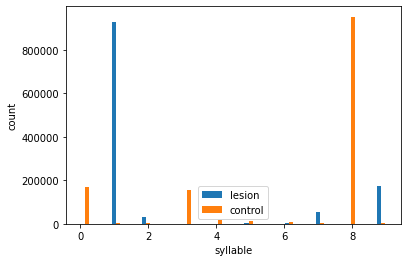

In [ ]:
#fig, ax1 = plt.subplots(figsize=(15,10))
import matplotlib.pyplot as plt
from kmeans_pytorch import kmeans_predict
plt.hist([cluster_ids_x[:1197550].tolist(),cluster_ids_x[1197550:].tolist()],bins=30,label=['lesion','control'])
#plt.hist(cluster_ids_x[1197550:],bins=30)
plt.legend()
plt.ylabel('count')
plt.xlabel('syllable')
print(cluster_ids_x.shape, cluster_centers.shape)

cluster_ids_y = kmeans_predict(
    x, cluster_centers, 'euclidean', device=torch.device('cuda:0'))